In [1]:
import psi4
import numpy as np
import matplotlib.pyplot as plt
#paramètres psi4
psi4.set_memory("500 MB")
numpy_memory = 2 #??
psi4.set_options({'guess': 'core',
                  'basis': 'cc-pvdz',
                  'scf_type': 'pk',
                  'e_convergence': 1e-8,
                  'reference': 'uhf'})

#paramètres pour nos tours de boucles HF
MAX_ITER = 30
E_conv = 1e-8
Ha_to_eV = 27.2114
power_precision = 1.e-16 #From PSI4 doc https://psicode.org/psi4manual/master/api/psi4.core.Matrix.html


In [2]:
mol = psi4.geometry(
    """
    H 0 0 0
    H 1 0 0 
    """)

In [3]:
#Définition des constantes du calcul
wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))
mints = psi4.core.MintsHelper(wfn.basisset())

nbs = wfn.nso()
print(nbs)
na = wfn.nalpha()
nb = wfn.nbeta()
nocc = max(na, nb)

T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
I = np.asarray(mints.ao_eri()) #Intégrales biélectroniques
H = T + V

X = mints.ao_overlap()
X.power(-0.5, power_precision)
X = np.asarray(X)
E_nuc = mol.nuclear_repulsion_energy()

10


In [4]:
def diag_F(F, n):
    Fp = X.dot(F).dot(X)
    e, Cp = np.linalg.eigh(Fp)
    P = np.zeros((nbs, nbs))
    C = np.dot(X, Cp)
    for mu in range(nbs):
        for nu in range(nbs):
            P[mu, nu] = sum([C[mu, a]*C[nu, a] for a in range(n)])
    return C,e,P

def calc_F(Pa, Pb):
    PT = Pa+Pb
    Fa = np.zeros((nbs, nbs))
    Fb = np.zeros((nbs, nbs))
    for mu in range(nbs):
        for nu in range(nbs):
            st, sa, sb = 0, 0, 0
            for lmbda in range(nbs):
                for sigma in range(nbs):
                    st += PT[lmbda, sigma] * I[mu, nu, sigma, lmbda]
                    Iech = I[mu, lmbda, sigma, nu]
                    sa += Pa[lmbda, sigma]*Iech
                    sb += Pb[lmbda, sigma]*Iech
            Fa[mu, nu] = H[mu, nu] + st - sa
            Fb[mu, nu] = H[mu, nu] + st - sb
    return Fa, Fb

def calc_E(Pa, Pb, Fa, Fb):
    Pt = Pa+Pb
    E = 0
    for mu in range(nbs):
        for nu in range(nbs):
            E += Pt[nu, mu]*H[mu, nu] + Pa[nu, mu] *Fa[mu, nu] + Pb[nu, mu]*Fb[mu, nu]
    return E/2
def hartree_to_ev(x):
    return x*Ha_to_eV

In [5]:
Fa = H #Première approx
Fb = H
Ca, ea, Pa = diag_F(Fa, na)
#print(Ca)
Cb, eb, Pb = diag_F(Fb, nb)
Eold = 10
Enew = calc_E(Pa, Pb, Fa, Fb)
i = 0
while (abs(Enew-Eold) > E_conv and i<MAX_ITER):
    Fa, Fb = calc_F(Pa, Pb)
    Ca, ea, Pa = diag_F(Fa, na)
    Cb, eb, Pb = diag_F(Fb, nb)
    Eold = Enew
    Enew = calc_E(Pa, Pb, Fa, Fb)
    print("Fin du tour n°{}, E_elec = {} eV".format(i, hartree_to_ev(Enew)))
    i += 1
Enew += E_nuc
print("Finalement, E = {} eV".format(hartree_to_ev(Enew)))
print()
E_psi = psi4.energy('SCF')
DeltaE = Enew - E_psi
print("Comparaison avec la référence de psi4 (en hartree)", np.format_float_scientific(DeltaE, precision = 3, exp_digits=2), "Ha") #faire une phrase

Fin du tour n°0, E_elec = -43.07527231520755 eV
Fin du tour n°1, E_elec = -44.13685261034509 eV
Fin du tour n°2, E_elec = -44.30260779948073 eV
Fin du tour n°3, E_elec = -44.330482912678086 eV
Fin du tour n°4, E_elec = -44.33532564555694 eV
Fin du tour n°5, E_elec = -44.33618598555637 eV
Fin du tour n°6, E_elec = -44.336341706975674 eV
Fin du tour n°7, E_elec = -44.33637033650008 eV
Fin du tour n°8, E_elec = -44.336375667734444 eV
Fin du tour n°9, E_elec = -44.33637667065329 eV
Fin du tour n°10, E_elec = -44.33637686083172 eV
Finalement, E = -29.936724110406086 eV

Comparaison avec la référence de psi4 (en hartree) 1.65e-09 Ha


# Etude de la dissociation de H2

In [6]:
h2 ="""
    H 0 0 0
    H 0 0 R
    units angstrom
    """

Energie finale: E = -20.73629497118043


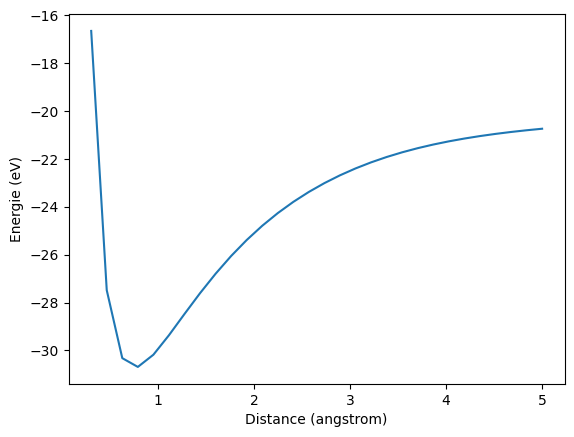

In [7]:
dist = np.linspace(0.3, 5, 30)
energies = []
for d in dist:
    # Build a new molecule at each separation
    mol = psi4.geometry(h2.replace('R', str(d)))
    
    # Compute the Counterpoise-Corrected interaction energy
    e = psi4.energy('SCF')
    # Place in a reasonable unit, Wavenumbers in this case
    # Append the value to our list
    #print("Distance: {} angstrom, Energie: {} Ha".format(d, hartree_to_ev(e)))
    energies.append(hartree_to_ev(e))
print("Energie finale: E = {}".format(energies[-1]))
plt.figure()
plt.xlabel("Distance (angstrom)")
plt.ylabel("Energie (eV)")
plt.plot(dist, energies)